In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

print(X_motion.shape)
print(Y_motion.shape)

(3680, 24)
(3680, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging[10]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.22409256,  0.13764513, -0.37768927,  0.25307816,
       -0.12646088, -0.36234671, -0.24581763,  0.12449852, -0.36482677,
       -0.27289456, -0.12420309, -0.38285276,  0.09404305, -0.01321102,
       -0.01135638, -0.01462876,  1.        ,  0.        ])

In [9]:
X_motion_FL_swinging[10, 18:22]

array([ 0.09404305, -0.01321102, -0.01135638, -0.01462876])

In [10]:
Y_motion_FL_swinging.shape

(1846, 4)

In [11]:
X_motion_FL_swinging[0:10, 0]

array([0. , 0.1, 0.1, 0. , 0.1, 0.1, 0. , 0.1, 0.1, 0. ])

### Linear Regression

In [23]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               #X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.95141623156553
RMSE:  0.033809100117987115
The lowest error is:  2.172826959800922e-05
The highest error is:  0.4337500615962746
The avg. error is:  0.01817682904018803


In [24]:
model_fl_relative_support_x.coef_

array([[ 9.21215537e-02,  2.22044605e-16, -7.77156117e-16,
         2.22933080e-01,  4.44089210e-16, -1.11022302e-16,
        -1.03811447e-01, -9.92177934e-01,  1.39991977e+00,
         3.30346889e-01, -1.19122471e+00, -2.23577066e-01,
        -1.87042129e+00,  5.52300992e-01]])

In [25]:
model_fl_relative_support_x.intercept_

array([-0.8231559])

Text(0, 0.5, 'Predictions')

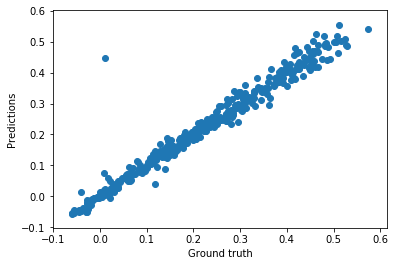

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [26]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               #X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.3837381095110912
RMSE:  0.009832804593947416
The lowest error is:  2.2730415521032832e-05
The highest error is:  0.06365687974397999
The avg. error is:  0.0065533361316130285


In [27]:
model_fl_relative_support_y.coef_

array([[ 9.34460236e-03,  8.55435514e-17, -3.05311332e-16,
         1.68173998e-02,  4.44089210e-16, -1.11022302e-16,
         4.70876686e-01, -1.17181580e+00,  5.30713271e-01,
         4.36797759e-01, -7.18398484e-01,  3.89175176e-01,
        -7.05528256e-01, -4.82654390e-01]])

In [28]:
model_fl_relative_support_y.intercept_

array([-0.51406359])

Text(0, 0.5, 'Predictions')

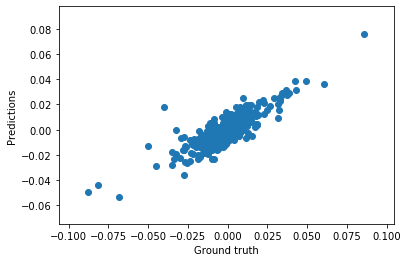

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')